In [137]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42


In [2]:
from scipy import stats

In [203]:
%run 'ks25_Read_epistasis.ipynb'

Running notebook 'ks01_Data_import.ipynb'...


Variables: 

- positions:			a pandas.DataFrame with information about position numbers, segments etc
- get_segment_of_a_genotype:	a function that return the segment of genotype (the most likely segment
				because sometimes it's not possible to say for sure)


Reading precalculated epistasis...
/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variables: 

- ep_dict: a dictionary, Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds. 
Tuples (mutA, mutB) are sorted by aa_position.

- get_ep_summary: a function that takes ep_dict as an argument and applies an arbitrary function to every pd.Series object. For example, ep_summary = get_ep_summary(ep_dict, np.mean)

- get_ep_summary_by_positions: a function that uses get_ep_summary and then averages results by position_pair. For example, get_ep_summary_by_positions(ep_dict, np.max, np.mean) wil

In [4]:
%run 'ks21_Read_impacts_of_mutations.ipynb'


Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



In [97]:
%run 'ks20_Read_ddG.ipynb'


Variables: 

- positions:			a pandas.DataFrame with information about position numbers, segments etc
- get_segment_of_a_genotype:	a function that return the segment of genotype (the most likely segment
				because sometimes it's not possible to say for sure)


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



In [6]:
structure_file = structure_predictions_folder + 'his3_24mer_assembly/' + 'his3_swiss_24mer_assembly.pdb'

In [45]:
ddG_set1 = pd.read_table(analysis_folder + 'Sasha/rosetta_runs/170522/' + '170522_aws_ddg_talaris__mutations_to_predict_ddG__set1.csv')
ddG_set2 = pd.read_table(analysis_folder + 'Sasha/rosetta_runs/170522/' + '170522_aws_ddg_talaris__mutations_to_predict_ddG__set2.csv')
ddG_set2[:5]

,mut_list_Scer,ddG,ddg_score2,ddg_score3,ddg_score1
0,102L,3.133333,-559.211,-559.263,-559.263
1,102L:104L,9.776000,-552.603,-552.603,-552.603
2,102L:105N,5.429333,-556.991,-556.923,-556.935
3,102L:105Q,2.861000,-559.580,-559.486,-559.488
4,102L:105H,1.947000,-560.408,-560.408,-560.480


In [46]:
%run 'ks35_Read_weights.ipynb'


Variables: 

- weights: pandas.DataFrame containing weights of mutations from neural network data (column 'weight') and weights, or fitness potential, of single mutants (column 'mutant_weight')



In [47]:
ddG_set2['mut_number'] = ddG_set2['mut_list_Scer'].apply(lambda s: s.count(':') + 1)
all_doubles = ddG_set2[ddG_set2['mut_number'] == 2].copy()
all_singles = ddG_set2[ddG_set2['mut_number'] == 1].copy()
all_singles.set_index('mut_list_Scer', inplace=True)

In [48]:
def norm_fraction(value, max_fraction, threshold=100):
    return min(255. * value / max_fraction, threshold) * (255./100)

all_doubles = ddG_set2[ddG_set2['mut_number'] == 2].copy()

all_doubles['mut_list_Scer_full'] = all_doubles['mut_list_Scer'].apply(lambda s: convert_to_full_mutations(s))

all_doubles['mutA'] = all_doubles['mut_list_Scer'].apply(lambda s: s.split(':')[0])
all_doubles['mutB'] = all_doubles['mut_list_Scer'].apply(lambda s: s.split(':')[1])
all_doubles['segment'] = all_doubles['mutA'].apply(lambda m: position_to_segment[int(m[:-1])])

all_doubles['mutA_ddG'] = all_doubles['mutA'].apply(lambda m: all_singles.loc[m].ddG)
all_doubles['mutB_ddG'] = all_doubles['mutB'].apply(lambda m: all_singles.loc[m].ddG)
all_doubles['ddG_sum_of_singles'] = all_doubles.apply(lambda df: df['mutA_ddG'] + df['mutB_ddG'], axis=1)
all_doubles['ddG_double_minus_singles'] = all_doubles['ddG'] - all_doubles['ddG_sum_of_singles']

In [49]:
def get_fraction_strong(ep_series, strong_epistasis_threshold=0.4, mode='abs'):
    assert mode in ['abs', 'both_signs']
    if mode == 'abs':
        strong = ep_series[np.abs(ep_series) > strong_epistasis_threshold]
        return 1. * len(strong) / len(ep_series)
    else:
        strong_negative = ep_series[ep_series < -1 * strong_epistasis_threshold]
        strong_positive = ep_series[ep_series > strong_epistasis_threshold]
        return 1. * len(strong_negative) / len(ep_series), 1. * len(strong_positive) / len(ep_series)

def get_value_from_ep_summary(ep_summary_dict, mut_comb):
    try:
        return ep_summary_dict[tuple(mut_comb.split(':'))]
    except KeyError:
        return None

    
ep_summaries = {}
ep_summaries['fraction_strong_03'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.3))
ep_summaries['fraction_strong_03_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.3))

ep_summaries['fraction_strong_04'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.4))
ep_summaries['fraction_strong_04_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.4))

ep_summaries['fraction_strong_05'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.5))
ep_summaries['fraction_strong_05_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.5))

ep_summaries['fraction_strong_06'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='abs', strong_epistasis_threshold=0.6))
ep_summaries['fraction_strong_06_both_signs'] = get_ep_summary(ep_dict, lambda s: get_fraction_strong(s, mode='both_signs', strong_epistasis_threshold=0.6))

ep_summaries['epistasis_mean'] = get_ep_summary(ep_dict, np.mean)
ep_summaries['epistasis_median'] = get_ep_summary(ep_dict, np.median)
ep_summaries['epistasis_std'] = get_ep_summary(ep_dict, np.std)

for k in ep_summaries:
    all_doubles[k] = all_doubles['mut_list_Scer'].apply(lambda m: get_value_from_ep_summary(ep_summaries[k], m))

In [50]:
def get_value_from_tuple(t, index):
    try:
        return t[index]
    except:
        return None

for c in all_doubles.columns:
    if '_both_signs' in c:
        all_doubles[c.rstrip('_both_signs') + '_negative'] = all_doubles[c].apply(lambda t: get_value_from_tuple(t, 0))
        all_doubles[c.rstrip('_both_signs') + '_positive'] = all_doubles[c].apply(lambda t: get_value_from_tuple(t, 1))

In [51]:
def get_mutant_weight(m):
    to_return = weights.loc[m].weight
    if type(to_return) != np.float64:
        return None
    else:
        return to_return

all_doubles['mutA_weight'] = all_doubles['mutA'].apply(lambda m: get_mutant_weight(m))
all_doubles['mutB_weight'] = all_doubles['mutB'].apply(lambda m: get_mutant_weight(m))

### Playground

/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


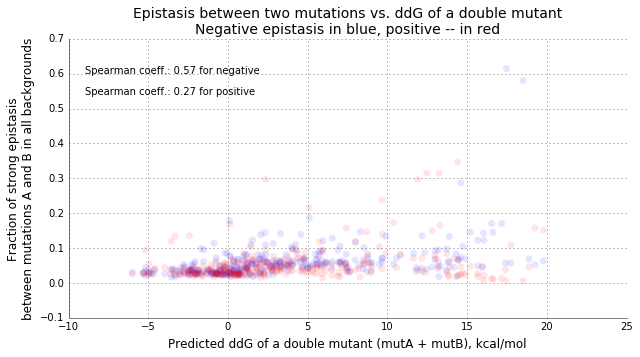

In [60]:
title = 'Epistasis between two mutations vs. ddG of a double mutant\nNegative epistasis in blue, positive -- in red'

x = 'ddG'
y1 = 'fraction_strong_04_negative'
y2 = 'fraction_strong_04_positive'

to_plot = all_doubles[[x, y1, y2, 'segment']].dropna()[all_doubles.segment.isin(['S2', 'S5'])]

plot_better()
plt.scatter(to_plot[x], to_plot[y1], edgecolor='none', alpha=0.1, s=50, color='blue')
plt.scatter(to_plot[x], to_plot[y2], edgecolor='none', alpha=0.1, s=50, color='red')
plt.title(title, fontsize=14)
plt.text(-9, 0.6, 'Spearman coeff.: %.2f for negative' %stats.spearmanr(to_plot[x], to_plot[y1])[0], ha='left')
plt.text(-9, 0.54, 'Spearman coeff.: %.2f for positive' %stats.spearmanr(to_plot[x], to_plot[y2])[0], ha='left')
# plt.ylim(0.0,0.3)
plt.xlabel('Predicted ddG of a double mutant (mutA + mutB), kcal/mol', fontsize=12)
plt.ylabel('Fraction of strong epistasis\nbetween mutations A and B in all backgrounds', fontsize=12)

### Fraction of strong

/Users/karen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


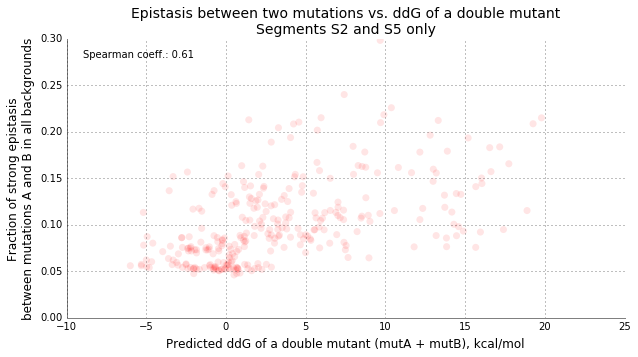

In [53]:
title = 'Epistasis between two mutations vs. ddG of a double mutant\nSegments S2 and S5 only'

x = 'ddG'
y = 'fraction_strong_04'

to_plot = all_doubles[[x, y, 'segment']].dropna()[all_doubles.segment.isin(['S2', 'S5'])]

plot_better()
plt.scatter(to_plot[x], to_plot[y], edgecolor='none', alpha=0.1, s=50, color='red')
plt.title(title, fontsize=14)
plt.text(-9, 0.28, 'Spearman coeff.: %.2f' %stats.spearmanr(to_plot[x], to_plot[y])[0], ha='left')
plt.ylim(0.0,0.3)
plt.xlabel('Predicted ddG of a double mutant (mutA + mutB), kcal/mol', fontsize=12)
plt.ylabel('Fraction of strong epistasis\nbetween mutations A and B in all backgrounds', fontsize=12)

### Std

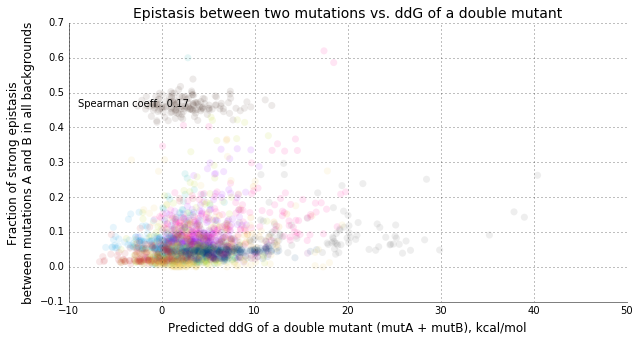

In [240]:
title = 'Epistasis between two mutations vs. ddG of a double mutant'#\nSegments S2 and S5 only'

x = 'ddG'
y = 'fraction_strong_04'

to_plot = all_doubles[[x, y, 'segment']].dropna()#[all_doubles.segment.isin(['S2', 'S5'])]

plot_better()
for row in to_plot.iterrows():
    plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.1, s=50, color=segment_colors[row[1]['segment'].split('_')[0]])
plt.title(title, fontsize=14)
plt.text(-9, 0.46, 'Spearman coeff.: %.2f' %stats.spearmanr(to_plot[x], to_plot[y])[0], ha='left')
# plt.ylim(0.0,0.3)
plt.xlabel('Predicted ddG of a double mutant (mutA + mutB), kcal/mol', fontsize=12)
# plt.ylabel('Standard deviation of epistasis values\nbetween mutations A and B in all backgrounds', fontsize=12)
plt.ylabel('Fraction of strong epistasis\nbetween mutations A and B in all backgrounds', fontsize=12)

In [241]:
%run 'ks23_Read_Lucas_sign_epistasis_data.ipynb'

94 positions under sign epistasis
59 positions under reciprocal sign epistasis
Pandas DataFrames available:
lucas_sign_epistasis, lucas_reciprocal_sign_epistasis

pBon threshold = 0.01
The following sets of positions are available:
all_sampled_positions, sign_epistasis_positions, reciprocal_sign_epistasis_positions


In [242]:
lucas_sign_epistasis['mutA'] = lucas_sign_epistasis.apply(lambda df: df['Perm'][0] + str(df['VarPos_absolute']) + df['Perm'][1], axis=1)
lucas_sign_epistasis['mutB'] = lucas_sign_epistasis.apply(lambda df: df['SubPerm'][0] + str(df['SubPos_absolute']) + df['SubPerm'][1], axis=1)
lucas_sign_epistasis['mut_list_Scer_full'] = lucas_sign_epistasis.apply(lambda df: ':'.join(sorted([df['mutA'], df['mutB']], key=lambda s: int(s[1:-1]))), axis=1)
lucas_sign_epistasis['mut_list_Scer'] = lucas_sign_epistasis.apply(lambda df: ':'.join(sorted([df['mutA'][1:], df['mutB'][1:]], key=lambda s: int(s[:-1]))), axis=1)
lucas_sign_epistasis.set_index('mut_list_Scer_full', inplace=True)

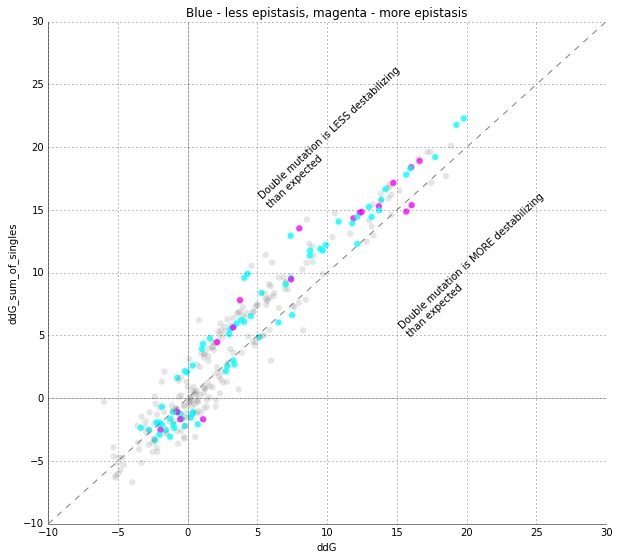

In [256]:
to_plot = all_doubles[all_doubles.segment.isin(['S2', 'S5'])]
x = 'ddG'
y = 'ddG_sum_of_singles'

plot_better(width=10, height=9)
x_line = np.arange(-10, 30, 0.1)
y_line = [v for v in x_line]
for row in to_plot.dropna().iterrows():
    try:
        sign = int(lucas_sign_epistasis.loc[row[1]['mut_list_Scer_full']].iloc[0]['pBon'] < 0.01)
        plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.8, s=40, color=mpl.cm.cool(255*sign))
    except:
        plt.scatter(row[1][x], row[1][y], edgecolor='none', s=40, color='gray', alpha=0.2)
plt.plot(x_line, y_line, color='gray', ls='--')
plt.axhline(0, color='gray', alpha=0.4)
plt.axvline(0, color='gray', alpha=0.4)
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel(x)
plt.ylabel(y)
# plt.colorbar(mpl.cm.Greens)
plt.text(5, 25, 'Double mutation is LESS destabilizing\nthan expected', rotation=43)
plt.text(15, 15, 'Double mutation is MORE destabilizing\nthan expected', rotation=43)
plt.title('Blue - less epistasis, magenta - more epistasis')

### Fraction of strong epistasis vs. ddG of double and single mutants

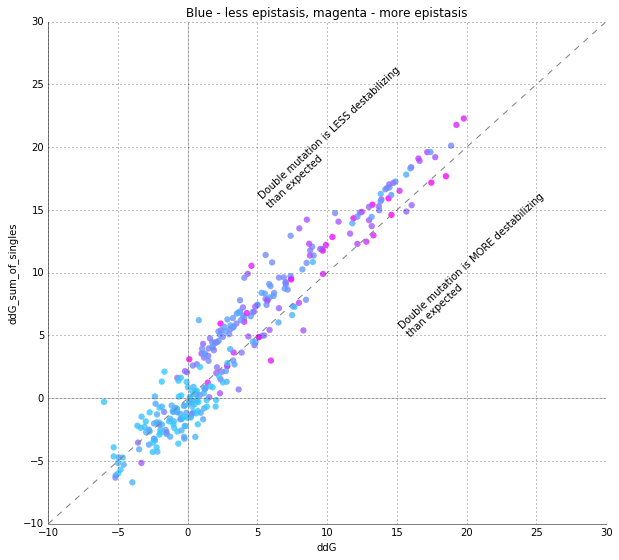

In [103]:
to_plot = all_doubles[all_doubles.segment.isin(['S2', 'S5'])]
x = 'ddG'
y = 'ddG_sum_of_singles'

plot_better(width=10, height=9)
x_line = np.arange(-10, 30, 0.1)
y_line = [v for v in x_line]
for row in to_plot.dropna().iterrows():
    plt.scatter(row[1][x], row[1][y], edgecolor='none', alpha=0.8, s=40, 
                color=mpl.cm.cool(int(row[1]['ep_fraction_strong_normalized'])))
#     break
plt.plot(x_line, y_line, color='gray', ls='--')
plt.axhline(0, color='gray', alpha=0.4)
plt.axvline(0, color='gray', alpha=0.4)
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel(x)
plt.ylabel(y)
# plt.colorbar(mpl.cm.Greens)
plt.text(5, 25, 'Double mutation is LESS destabilizing\nthan expected', rotation=43)
plt.text(15, 15, 'Double mutation is MORE destabilizing\nthan expected', rotation=43)
plt.title('Blue - less epistasis, magenta - more epistasis')

In [64]:
ddG_set1[['mut_list_Scer', 'ddG']]

,mut_list_Scer,ddG
0,141C,6.938000
1,141C:143I,8.702667
2,141C:143T,10.040000
3,141S,2.252000
4,141S:143I,6.199000
5,141S:143T,6.219333
6,143I,4.515000
7,143T,4.561333


In [188]:
subset.columns

Index([u'aa_seq', u't0_fr', u't1_fr', u't2_fr', u't0_fr_var', u't1_fr_var',
       u't2_fr_var', u'size', u'y0', u's', u'y0_std', u's_std', u'nonsense',
       u'len', u'nogap', u'stop', u'shift', u'middle', u'mut_list', u'nat',
       u'lib', u'nat_lib', u'dist_Agos', u'dist_Anid', u'dist_Calb',
       u'dist_Cgla', u'dist_Cgui', u'dist_Clus', u'dist_Cpar', u'dist_Ctro',
       u'dist_Dhan', u'dist_Klac', u'dist_Kwal', u'dist_Lelo', u'dist_Ncra',
       u'dist_Sbay', u'dist_Scas', u'dist_Scer', u'dist_Sjap', u'dist_Sklu',
       u'dist_Soct', u'dist_Spom', u'dist_Ylip', u'dist_node_22',
       u'dist_node_23', u'dist_node_24', u'dist_node_25', u'dist_node_26',
       u'dist_node_27', u'dist_node_28', u'dist_node_29', u'dist_node_30',
       u'dist_node_31', u'dist_node_32', u'dist_node_33', u'dist_node_34',
       u'dist_node_35', u'dist_node_36', u'dist_node_37', u'dist_node_38',
       u'dist_node_39', u'dist_node_40', u'dist_node_41', u'dist_min_sp',
       u'dist_min_all', u's_ori

In [ ]:
[('202A', '203S'), ('181H', '202A'), ('181H', '203S'), ('18S', '25E'), ('202A', '206L')]

In [236]:
counter = 0
subset = data_natural['S5_scaled'].fillna('').set_index('mut_list_Scer')
for mut_pair in sorted(ep_summaries['epistasis_mean'], key = lambda k: ep_summaries['epistasis_mean'][k]):
    segment = get_segment_of_a_genotype(':'.join(mut_pair))
    if segment == 'S5':
# for mut_pair in [('141C', '143I'), ('141S', '143I'), ('141C', '143T'), ('141S', '143T')]:
# for mut_pair in [('181H', '202A'), ('181H', '203S'), ('202A', '206L')]:
        ep = pd.DataFrame(ep_dict[mut_pair])
        ep.columns = ['epistasis']
        ep.reset_index(inplace=True)
        try:
            print mut_pair
            ep['aa_seq'] = ep.apply(lambda s: subset.loc[s['wt']]['aa_seq'], axis=1)
#             print mut_pair
        #     display(ep)
            ep.to_hdf('/Users/karen/Downloads/' + '_'.join(mut_pair) + '.hdf', 'data')
            counter += 1
        except:
            pass
    if counter == 15:
        break

('202A', '203S')
('181H', '202A')
('181H', '203S')
('202A', '206L')
('203S', '206L')
('181H', '206L')
('202A', '209K')
('208E', '209K')
('181H', '209K')
('206L', '209K')
('202A', '208E')
('202A', '206S')
('181Y', '202A')
('203S', '206S')
('203S', '209K')
('206L', '208E')
('181H', '208E')
('181H', '206S')
('189A', '207T')
('183N', '206L')
('208E', '211E')
('181Y', '203S')
('206S', '209K')
('183N', '202A')
('202A', '211E')
('207T', '210D')
('204I', '206L')
('183N', '208E')
('181Y', '206L')
('183T', '189A')
('189A', '210D')
('181Y', '209K')
('206L', '211E')
('209K', '211E')
('183N', '209K')
('202A', '204I')
('183N', '204I')
('181H', '211E')
('202A', '205T')
('183T', '206L')
('183T', '204I')
('181Y', '208E')
('206S', '208E')
('183T', '208E')
('203S', '208E')
('204I', '209K')
('181H', '183N')
('183N', '203S')
('183N', '211E')
('204I', '207T')
('181Y', '205T')
('183N', '206S')
('204I', '205T')
('206S', '211E')
('201K', '206S')
('201K', '210D')
('201K', '207T')
('203S', '211E')
('181H', '205T

In [98]:
ddG_table = ddG_set2.set_index('mut_list_Scer')

differences = {'143I':[], '143T':[]}
for mutation in natural_unique_single_mutations['S2_scaled']:
    if '141' not in mutation and '143' not in mutation:
        mutant_CI = ':'.join(sorted(['141C', '143I', mutation], key=lambda m: int(m[:-1])))
        mutant_SI = ':'.join(sorted(['141S', '143I', mutation], key=lambda m: int(m[:-1])))
        
        mutant_CT = ':'.join(sorted(['141C', '143T', mutation], key=lambda m: int(m[:-1])))
        mutant_ST = ':'.join(sorted(['141S', '143T', mutation], key=lambda m: int(m[:-1])))
        
        differences['143I'].append(ddG_table.loc[mutant_SI].ddG - ddG_table.loc[mutant_CI].ddG)
        differences['143T'].append(ddG_table.loc[mutant_ST].ddG - ddG_table.loc[mutant_CT].ddG)

Ttest_relResult(statistic=3.3773006308026452, pvalue=0.0041464772152637833)


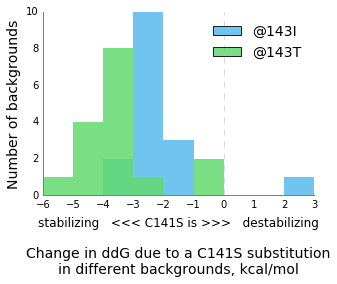

In [178]:
plot_better(grid='', width=4.8, height=4)
plt.hist(differences['143I'], label='@143I', edgecolor='none', range=(-7,7), bins=14, alpha=0.85, color='#57baec')
plt.hist(differences['143T'], label='@143T', edgecolor='none', range=(-7,7), bins=14, alpha=0.85, color='#62d96e')
plt.axvline(0, color='gray', ls='--', alpha=0.3)
# plt.text(0, -1, '<<< C141S is neutral >>>', ha='center')
plt.text(-1.5, -1.7, 'stabilizing   <<< C141S is >>>   destabilizing', ha='center', fontsize=12)
# plt.text(1.5, -1.4, 'C141S is destabilizing >>>', ha='center', fontsize=12)

plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.title('')
plt.xlabel(u'\n\nChange in ddG due to a C141S substitution\nin different backgrounds, kcal/mol', fontsize=14)
plt.ylabel('Number of backgrounds', fontsize=14)
print stats.ttest_rel(differences['143I'], differences['143T'])
plt.xlim(-6,3)
plt.tight_layout()
plt.savefig('/Users/karen/Downloads/C141S_in_the_background_of_143.png', dpi=300)

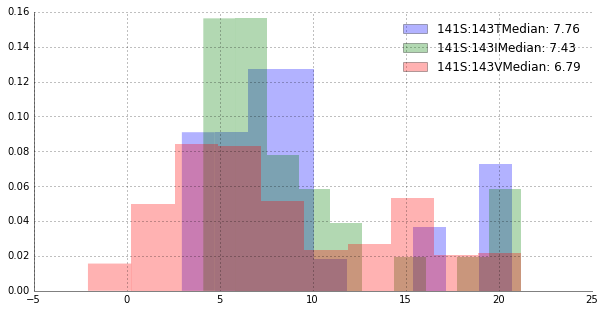

In [80]:
stateA = '141S'
stateB = '143T'
stateC = '143I'
triples1 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateB))]
triples2 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateC))]
triples3 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA))]

plot_better()
plt.hist(triples1.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateB + 'Median: %.2f' %triples1.ddG.median(), normed=True)
plt.hist(triples2.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateC + 'Median: %.2f' %triples2.ddG.median(), normed=True)
plt.hist(triples3.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + '143V' + 'Median: %.2f' %triples3.ddG.median(), normed=True)
plt.legend(loc='upper right', frameon=False)

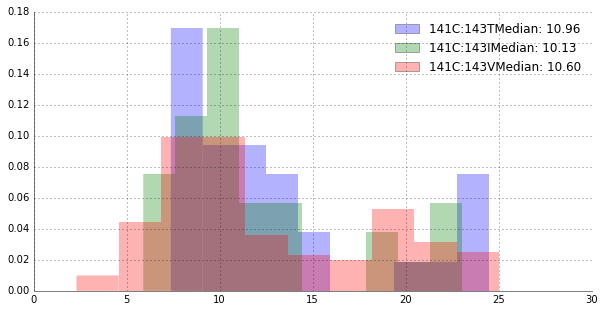

In [81]:
stateA = '141C'
stateB = '143T'
stateC = '143I'
triples1 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateB))]
triples2 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateC))]
triples3 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA))]

plot_better()
plt.hist(triples1.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateB + 'Median: %.2f' %triples1.ddG.median(), normed=True)
plt.hist(triples2.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateC + 'Median: %.2f' %triples2.ddG.median(), normed=True)
plt.hist(triples3.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + '143V' + 'Median: %.2f' %triples3.ddG.median(), normed=True)
plt.legend(loc='upper right', frameon=False)

In [ ]:
stateA = '141C'
stateB = '143T'
stateC = '143I'
triples1 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateB))]
triples2 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA)) & (predicted_ddG.index.str.contains(stateC))]
triples3 = predicted_ddG[(predicted_ddG.mut_number == 3) & (predicted_ddG.index.str.contains(stateA))]

plot_better()
plt.hist(triples1.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateB + 'Median: %.2f' %triples1.ddG.median(), normed=True)
plt.hist(triples2.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + stateC + 'Median: %.2f' %triples2.ddG.median(), normed=True)
plt.hist(triples3.ddG, edgecolor='none', alpha=0.3, label=stateA + ':' + '143V' + 'Median: %.2f' %triples3.ddG.median(), normed=True)
plt.legend(loc='upper right', frameon=False)